# Getting Started

In [212]:
import os
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from pathlib import Path

from unittest.mock import MagicMock,patch

AUTOTUNE = tf.data.AUTOTUNE

In [213]:
class Config:
    def __init__(self):
        self.cwd = Path(os.getcwd())
        self.csv_path = self.cwd.joinpath('mc_screenshots').joinpath('features_and_decisions.csv')
        self.screenshots_path = self.cwd.joinpath('mc_screenshots').joinpath('screenshots')
        self.batch_size = 32
        self.img_height = 9 * 16
        self.img_width = 16 * 16
        self.epochs = 16
        self.seed = 124
        self.validation_split = 0.2

# Preparing classes for Model

In [214]:
class ModelBuilder:
    def __init__(self, img_height, img_width, num_of_classes):
        self.img_height = img_height
        self.img_width = img_width
        self.num_of_classes = num_of_classes

    def build_model(self):
        self.resize_and_rescale = tf.keras.Sequential([
            tf.keras.layers.Resizing(self.img_height, self.img_width),
            tf.keras.layers.Rescaling(1. / 255)
        ])

        self.data_augmentation = tf.keras.Sequential(
            [
                tf.keras.layers.RandomFlip("horizontal"),
                tf.keras.layers.RandomRotation(0.1),
                tf.keras.layers.RandomZoom(0.1),
            ]
        )

        self.model = tf.keras.Sequential(
            [
                self.resize_and_rescale,
                self.data_augmentation,
                tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
                tf.keras.layers.MaxPooling2D(),
                tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
                tf.keras.layers.MaxPooling2D(),
                tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
                tf.keras.layers.MaxPooling2D(),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dense(self.num_of_classes, name="outputs"),
            ]
        )

In [215]:
class ModelCompiler:
    @staticmethod
    def compile(model):
        model.compile(
            optimizer="adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"]
        )

In [216]:
class ModelTrainer:
    def train(self, model, train_ds, val_ds, epochs, class_weights):
        self.history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, class_weight=class_weights)

In [217]:
class DataSetBuilder:
    def __init__(self, screenshots_path, seed, validation_split, image_size, batch_size):
        self.screenshots_path = screenshots_path
        self.seed = seed
        self.validation_split = validation_split
        self.image_size = image_size
        self.batch_size = batch_size
    
    def build_dataset(self, subset):
        dataset = tf.keras.utils.image_dataset_from_directory(
            self.screenshots_path,
            validation_split = self.validation_split,
            subset=subset,
            seed=self.seed,
            image_size=self.image_size,
            batch_size=self.batch_size
        )

        self.class_names = dataset.class_names

        return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [218]:
class WeightsBuilder:
    @staticmethod
    def get_class_counts_from_directory(screenshots_path):
        class_counts = {}
        
        for class_name in os.listdir(screenshots_path):
            class_folder = os.path.join(screenshots_path, class_name)
            
            if os.path.isdir(class_folder):
                file_count = len([f for f in os.listdir(class_folder) if f.lower().endswith(('png', 'jpg'))])
                class_counts[class_name] = file_count
        
        return class_counts
    
    @staticmethod
    def get_class_weights(class_counts):
        total_samples = sum(class_counts.values())
        class_weights = {}
        for class_name, count in class_counts.items():
            class_weights[class_name] = total_samples / count
        
        return {i: class_weights[class_name] for i, class_name in enumerate(class_counts.keys())}

In [219]:
class DataVisualizationHelper:
    @staticmethod
    def show_model_summary(model):
        model.summary()

    @staticmethod
    def show_augmentation(train_ds, data_augmentation):
        plt.figure(figsize=(10, 10))
        plt.title("Augmentation showcase")
        for images, _ in train_ds.take(1):
            for i in range(9):
                augmented_images = data_augmentation(images)
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(augmented_images[0].numpy().astype("uint8"))
                plt.axis("off")

    @staticmethod
    def show_accuracy(history, epochs):
        acc = history.history["accuracy"]
        val_acc = history.history["val_accuracy"]

        loss = history.history['loss']
        val_loss = history.history['val_loss']
        
        epochs_range = range(epochs)

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label="Training Accuracy")
        plt.plot(epochs_range, val_acc, label="Validation Accuracy")
        plt.legend(loc="lower right")
        plt.title("Training and Validation Accuracy")

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label="Training Loss")
        plt.plot(epochs_range, val_loss, label="Validation Loss")
        plt.legend(loc="upper right")
        plt.title("Training and Validation Loss")
        plt.show()

    @staticmethod
    def show_confusion_matrix(model, val_ds, class_names):
        y_true = np.concatenate([y for x, y in val_ds], axis=0)
        y_pred = np.argmax(model.predict(val_ds), axis=-1)

        cf_matrix = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

    @staticmethod
    def show_data_set_stats(train_ds):
        for images, labels in train_ds.take(1):
            print(f"Image batch shape: {images.shape}")
            print(f"Label batch shape: {labels.shape}")

    @staticmethod
    def show_data_set_images(train_ds):
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
          for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

# Preliminary analysis and Training

In [220]:
config = Config()

# prepare builder
data_set_builder = DataSetBuilder(
    config.screenshots_path,
    config.seed,
    config.validation_split,
    (config.img_height, config.img_width),
    config.batch_size,
)

# build datasets
train_ds = data_set_builder.build_dataset("training").shuffle(1000)
val_ds = data_set_builder.build_dataset("validation")

# cache class_names and num_classes
class_names = data_set_builder.class_names
num_classes = len(class_names)
class_counts = WeightsBuilder.get_class_counts_from_directory(config.screenshots_path)
class_weights = WeightsBuilder.get_class_weights(class_counts)

# build model
model_builder = ModelBuilder(config.img_height, config.img_width, num_classes)
model_builder.build_model()

# compile model
ModelCompiler.compile(model_builder.model)

Found 6205 files belonging to 6 classes.
Using 4964 files for training.
Found 6205 files belonging to 6 classes.
Using 1241 files for validation.


{'archering': 1967, 'building': 499, 'fighting': 1885, 'mining': 500, 'swimming': 854, 'walking': 500}
{0: 3.1545500762582614, 1: 12.434869739478957, 2: 3.2917771883289126, 3: 12.41, 4: 7.265807962529274, 5: 12.41}
Image batch shape: (32, 144, 256, 3)
Label batch shape: (32,)


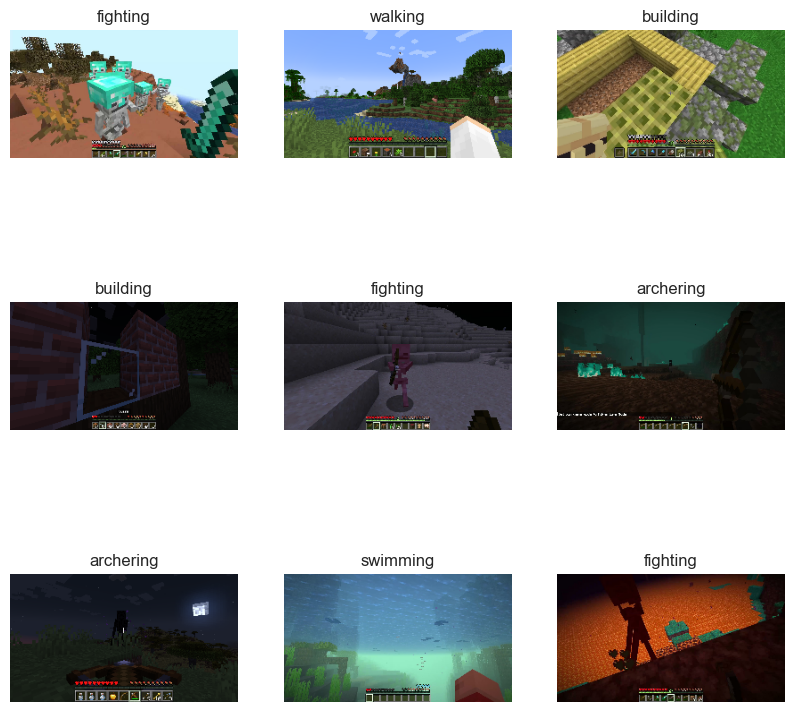

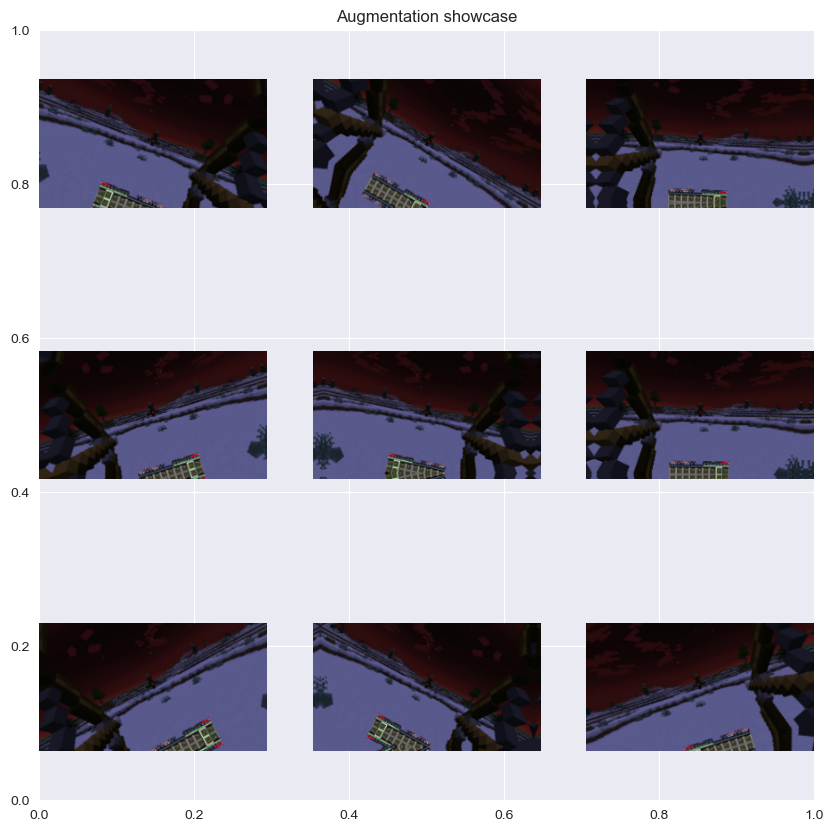

In [221]:
print(class_counts)
print(class_weights)
DataVisualizationHelper.show_data_set_stats(train_ds)
DataVisualizationHelper.show_data_set_images(train_ds)
DataVisualizationHelper.show_augmentation(train_ds, model_builder.data_augmentation)

In [222]:
# train model
model_trainer = ModelTrainer()
model_trainer.train(model_builder.model, train_ds, val_ds, config.epochs, class_weights)

Epoch 1/16
156/156 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.4677 - loss: 8.0353 - val_accuracy: 0.7325 - val_loss: 0.8131
Epoch 2/16
156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.7582 - loss: 3.9655 - val_accuracy: 0.6857 - val_loss: 0.9645
Epoch 3/16
156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.8431 - loss: 2.7838 - val_accuracy: 0.7937 - val_loss: 0.5951
Epoch 4/16
156/156 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.8782 - loss: 2.1789 - val_accuracy: 0.8952 - val_loss: 0.2869
Epoch 5/16
156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.9197 - loss: 1.5441 - val_accuracy: 0.8453 - val_loss: 0.5400
Epoch 6/16
156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.9251 - loss: 1.2825 - val_accuracy: 0.8848 - val_loss: 0.4281
Epoch 7/16
156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.9347 - loss: 1.1010 - val_accuracy: 0.9315 - val_loss: 0.2002
Epoch 8/16
156/156 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.9508 - loss: 0

# Analysis and Evaluation of results

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


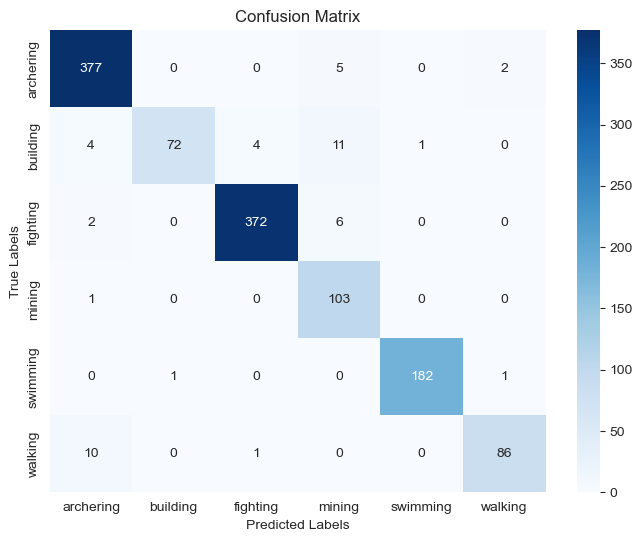

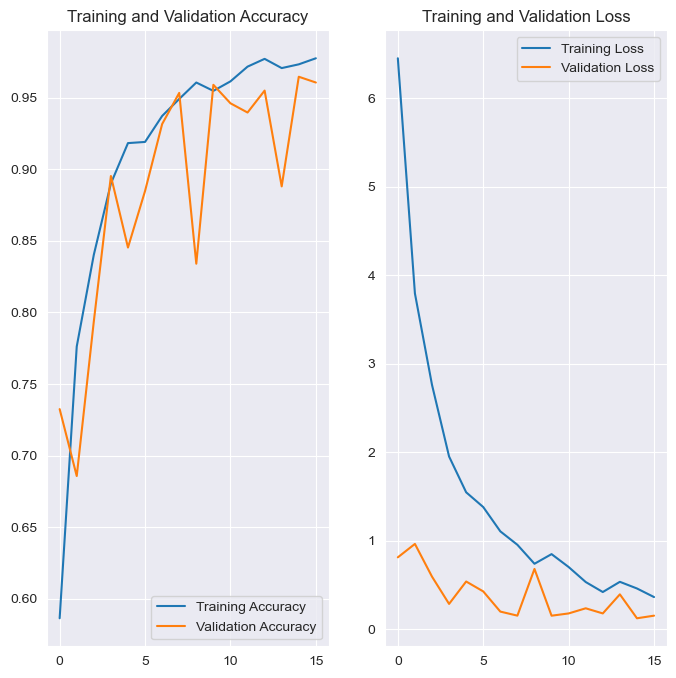

In [223]:
DataVisualizationHelper.show_confusion_matrix(model_builder.model, val_ds, class_names)
DataVisualizationHelper.show_accuracy(model_trainer.history, config.epochs)

In [224]:
class ModelPrediction:
    def __init__(self, model, img_height, img_width):
        self.model = model
        self.target_size = (img_height, img_width)
    
    def predict(self, img_path):
        img = tf.keras.utils.load_img(img_path, target_size=self.target_size, color_mode="rgb")
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        predictions = self.model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis("off")

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[np.argmax(score)], 100 * np.max(score))
        )

        plt.show()

In [225]:
model_prediction = ModelPrediction(model_builder.model, config.img_height, config.img_width)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
This image most likely belongs to archering with a 100.00 percent confidence.


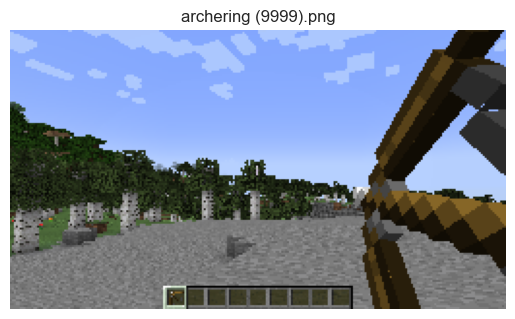

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
This image most likely belongs to building with a 100.00 percent confidence.


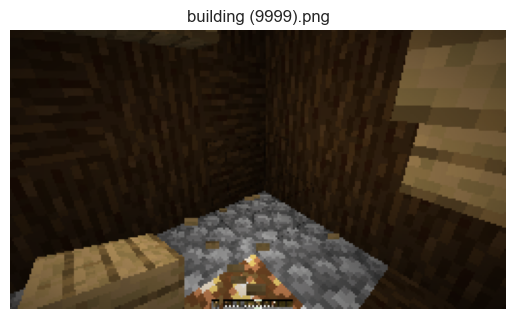

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
This image most likely belongs to fighting with a 98.12 percent confidence.


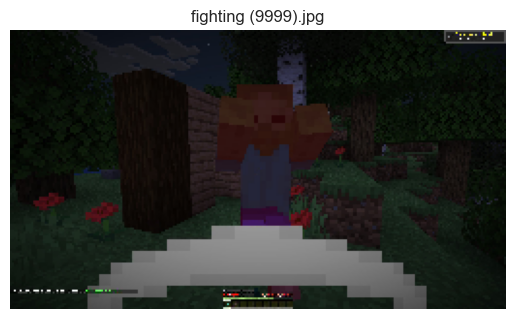

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
This image most likely belongs to archering with a 46.06 percent confidence.


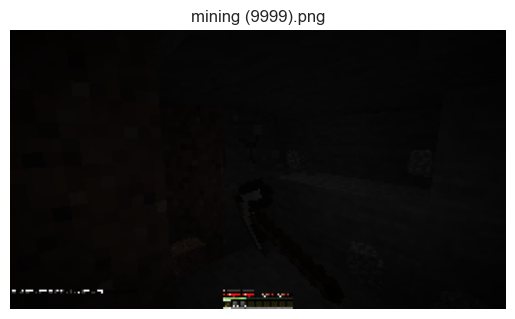

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
This image most likely belongs to swimming with a 100.00 percent confidence.


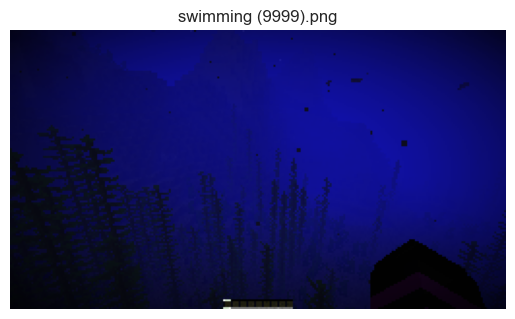

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
This image most likely belongs to swimming with a 93.58 percent confidence.


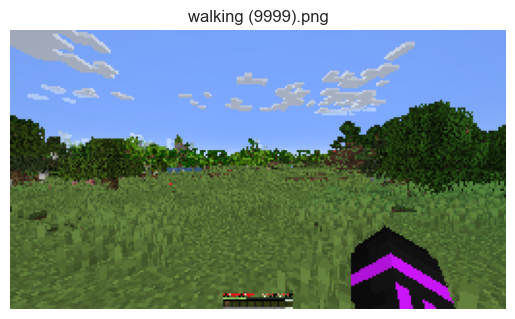

In [226]:
custom_images = [
    'archering (9999).png',
    'building (9999).png',
    'fighting (9999).jpg',
    'mining (9999).png',
    'swimming (9999).png',
    'walking (9999).png'
]

for custom_image in custom_images:
    path = Path(config.screenshots_path).joinpath(custom_image)
    model_prediction.predict(path)

In [ ]:
class ModelPersistance:
    @staticmethod
    def save(model, path):
        model.save(path)
    @staticmethod
    def load(path):
        return tf.keras.models.load_model(path)

In [ ]:
ModelPersistance.save(model_builder.model, config.cwd.joinpath('model.keras'))

In [ ]:
loaded_model = ModelPersistance.load(config.cwd.joinpath('model.keras'))
model_prediction = ModelPrediction(loaded_model, config.img_height, config.img_width)
model_prediction.predict(Path(config.screenshots_path).joinpath('fighting (9999).jpg'))

# Unit testing

In [227]:
def test_model_build():
    builder = ModelBuilder(config.img_height, config.img_width, num_classes)
    assert builder is not None
    builder.build_model()
    assert builder.model is not None
    assert isinstance(builder.model, tf.keras.Sequential)

def test_model_compiler():
    model = tf.keras.Sequential([tf.keras.layers.Dense(1)])
    ModelCompiler.compile(model)
    assert model.optimizer is not None

def test_model_trainer():
    trainer = ModelTrainer()

    model = MagicMock()
    train_ds = MagicMock()
    val_ds = MagicMock()

    trainer.train(model, train_ds, val_ds, epochs=5, class_weights=class_weights)
    model.fit.assert_called_once_with(train_ds, validation_data=val_ds, epochs=5, class_weight=class_weights)

def test_dataset_builder():
    with patch("tensorflow.keras.utils.image_dataset_from_directory") as mock_dataset:
        mock_dataset.return_value = MagicMock()
        builder = DataSetBuilder("path", 42, 0.2, (32, 32), 32)
        dataset = builder.build_dataset("training")
        assert dataset is not None
        mock_dataset.assert_called_once_with(
            "path",
            validation_split=0.2,
            subset="training",
            seed=42,
            image_size=(32, 32),
            batch_size=32
        )

In [228]:
test_model_build()
test_model_trainer()
test_model_trainer()
test_dataset_builder()